In [1]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts

from typhon.arts.workspace import Workspace

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts
Loading ARTS API from: /home/simon/build/arts_production/arts/src/arts_api.so


In [2]:
ws = Workspace()
ws.yCalc?

In [3]:
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

In [5]:
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )

In [6]:
ws.stokes_dim = 1
ws.cloudboxOff()
ws.jacobianOff()

In [7]:
ws.VectorNLogSpace( ws.p_grid, 200, 1013e2, 10.0 )
ws.abs_speciesSet( species=["N2", "O2", "H2O"] )
# Read a line file and a matching small frequency grid
ws.abs_linesReadFromSplitArtscat(
    ws.abs_species,
    "spectroscopy/Perrin/",
    10e9,
    250e9
    )
# Sort the line file according to species
ws.abs_lines_per_speciesCreateFromLines()

In [8]:
from typhon.arts.workspace.variables import *

# Atmospheric scenario
ws.AtmRawRead( basename="planets/Earth/Fascod/midlatitude-summer/midlatitude-summer" )
# Non reflecting surface
ws.VectorSetConstant( surface_scalar_reflectivity, 1, 0.1 )
ws.Copy( surface_rtprop_agenda, ws.surface_rtprop_agenda__Specular_NoPol_ReflFix_SurfTFromt_surface )
# Create a frequency grid
ws.VectorNLinSpace( f_grid, 1000, 10e+9, 250e+9 )
# No sensor properties
ws.sensorOff()
# We select here to use Planck brightness temperatures
ws.StringSet( iy_unit, "PlanckBT" )
# Extract optical depth as auxiliary variables
ws.ArrayOfStringSet( iy_aux_vars, [ "Optical depth"] )
# Create vector container for the optical depth
odepth = ws.VectorCreate()


In [9]:
import numpy as np
# Atmosphere and surface
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()
ws.Extract( ws.z_surface, ws.z_field, 0 )
ws.Extract( ws.t_surface, ws.t_field, 0 )

# Definition of sensor position and line of sight (LOS)
ws.MatrixSet( ws.sensor_pos, np.array([[0.0]])) # 10e3 for sensor in z = 10 km
ws.MatrixSet( ws.sensor_los, np.array([[0.0]])) # zenith angle: 0 looking up, 180 looking nadir

# Perform RT calculations
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.yCalc()

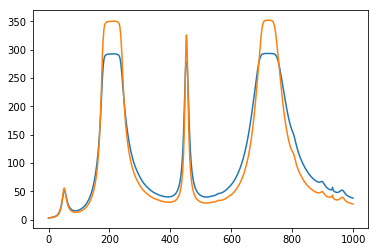

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ws.y)
t = np.asarray(ws.t_field)
t *= 1.2
ws.yCalc()
plt.plot(ws.y)